In [1]:
import pandas as pd
import joblib
import seaborn as sb
import matplotlib.pyplot as plt
#sb.set()
import truvari
import glob

In [19]:
pop_colours = {
    'AFR': '#FF0000',
    'AMR': '#008000',
    'EAS': '#00FFFF',
    'EUR': '#90EE90',
    'MES': '#FFA500',
    'OCN': '#8B0000',
    'SAS': '#1E90FF',
    'KES': '#808080',
    'CMS': '#0000FF',
}

In [2]:
data = []
for i in glob.glob("results/*lite.jl"):
    d = joblib.load(i)
    print(d.columns)
    data.append(d)
data = pd.concat(data)

Index(['id', 'svtype', 'svlen', 'szbin', 'qual', 'filter', 'is_pass', 'AC',
       'NS', 'AF', 'CALLRATE', 'END', 'SVLEN', 'SVTYPE', 'Biallelic', 'GD_AF',
       'GD_ID', '1000g_event', 'GTCNT', 'Gene_name'],
      dtype='object')
Index(['id', 'svtype', 'svlen', 'szbin', 'qual', 'filter', 'is_pass', 'AC',
       'NS', 'AF', 'CALLRATE', 'END', 'SVLEN', 'SVTYPE', 'Biallelic', 'GD_AF',
       'GD_ID', '1000g_event', 'GTCNT', 'Gene_name'],
      dtype='object')
Index(['id', 'svtype', 'svlen', 'szbin', 'qual', 'filter', 'is_pass', 'AC',
       'NS', 'AF', 'CALLRATE', 'END', 'SVLEN', 'SVTYPE', 'Biallelic', 'GD_AF',
       'GD_ID', '1000g_event', 'GTCNT', 'Gene_name'],
      dtype='object')


In [3]:
bins = []
labels = []
for i in range(5, 101, 5):
    bins.append(i/ 100)
    labels.append(f"[{i-5},{i})")
bins.insert(0, 0)
data["AFBin"] = pd.cut(data["AF"], bins, labels=labels)
data["GDAFBin"] = pd.cut(data["GD_AF"], bins, labels=labels)

data["filter"] = data["filter"].apply(lambda x: x[0])
data['is_gnomAD'] = ~data["GD_ID"].isna()
data['is_1000g'] = ~data["1000g_event"].isna()
data['known'] = data['is_gnomAD'] | data['is_1000g']
data['count'] = 1
pass_only = data["filter"] == 'PASS'

In [4]:
filtered = data.loc[~pass_only]
data = data.loc[pass_only]

In [5]:
new_bins = [0, 1000, 5000, 10000, 20000, 50000, 100000, 1e7]
labels = ["[0,1kb)", "[1kb, 5kb)", "[5kb, 10kb)", "[10kb, 20kb)", "[20kb, 50kb)", "[50kb, 100kb)", "100kb+"]
data["big_bins"] = pd.cut(data["svlen"], new_bins, labels=labels)

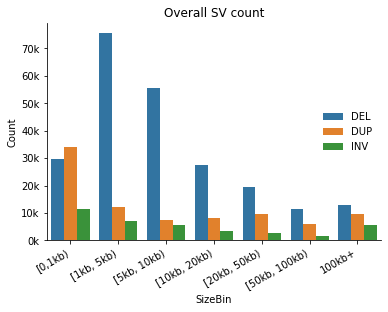

In [71]:
p = sb.countplot(data=data, x="big_bins", hue="svtype", hue_order=["DEL", "DUP", "INV"])
sb.despine()
sb.move_legend(p, "right",
    #bbox_to_anchor=(.5, 1),
    title=None,
    frameon=False,)
p.set(title="Overall SV count", xlabel="SizeBin", ylabel="Count")
hide = plt.yticks(range(0, 80000, 10000), ["{:,d}k".format(x // 1000) for x in range(0, 80000, 10000)])
hide = plt.xticks(rotation=30, ha='right')

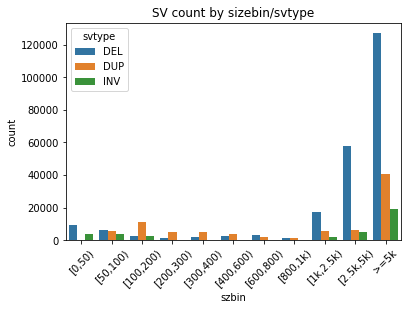

In [69]:
p = sb.countplot(data=data, x="szbin", hue="svtype", hue_order=["DEL", "DUP", "INV"])
p.set(title="SV count by sizebin/svtype")
hide = plt.xticks(rotation=45)

In [7]:
data["svlen"].describe().astype(int)

count     355954
mean       48121
std       294380
min           11
25%         2026
50%         5399
75%        15704
max      9984015
Name: svlen, dtype: int64

In [8]:
#pd.options.display.max_rows = None
view = pd.DataFrame(data.groupby(['svtype', 'szbin']).size()[["DEL", "DUP", "INV"]].values.reshape(3, 11),
            index=["DEL", "DUP", "INV"], columns=truvari.SZBINS)
view["Total"] = view.sum(axis=1)
view.loc["Total"] = view.sum(axis=0)
view.style.format("{:,d}")

# NEW VCFs

,"[0,50)","[50,100)","[100,200)","[200,300)","[300,400)","[400,600)","[600,800)","[800,1k)","[1k,2.5k)","[2.5k,5k)",>=5k,Total
DEL,"9,314","6,175","2,737","1,336","2,213","2,832","3,215","1,657","17,368","57,920","127,050","231,817"
DUP,55,"5,573","11,391","4,809","5,222","3,756","1,935","1,279","5,811","6,283","40,797","86,911"
INV,"3,760","3,606","2,648",282,169,316,257,234,"2,134","4,883","18,937","37,226"
Total,"13,129","15,354","16,776","6,427","7,604","6,904","5,407","3,170","25,313","69,086","186,784","355,954"


count     186784
mean       89985
std       401818
min         5000
25%         7806
50%        14342
75%        50683
max      9984015
Name: svlen, dtype: int64

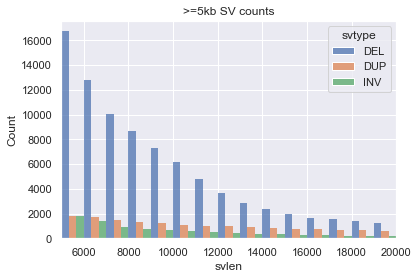

In [9]:
view = data[data["szbin"] == ">=5k"]
p = sb.histplot(data=view, x="svlen", hue="svtype", 
                hue_order=["DEL", "DUP", "INV"], 
                multiple="dodge",
                binwidth=1000)#=list(range(10000, 100000)))
hide = p.set(xlim=(5000, 20000), title=">=5kb SV counts")
view["svlen"].describe().astype(int)

In [10]:
view_p = ((data.groupby(["svtype", "is_gnomAD", "is_1000g"]).size() / data.groupby(["svtype"]).size()).dropna() * 100).round(1)
view_cnt = data.groupby(["svtype", "is_gnomAD", "is_1000g"]).size()
view = pd.concat([view_cnt, view_p], axis=1)
view.columns = ["Count", "PctOfSVtype"]
view.loc[["DEL", "DUP", "INV"]]

Count  PctOfSVtype
svtype is_gnomAD is_1000g                     
DEL    False     False     100087         43.2
                 True       21219          9.2
       True      False      57300         24.7
                 True       53211         23.0
DUP    False     False      43695         50.3
                 True        7740          8.9
       True      False      24671         28.4
                 True       10805         12.4
INV    False     False      20012         53.8
                 True        6380         17.1
       True      False       8722         23.4
                 True        2112          5.7

In [11]:
view_p = ((data.groupby(["svtype", "known"]).size() / data.groupby(["svtype"]).size()).dropna() * 100).round(1)
view_cnt = data.groupby(["svtype", "known"]).size()
view = pd.concat([view_cnt, view_p], axis=1)
view.columns = ["Count", "PctOfSVtype"]
view.loc[["DEL", "DUP", "INV"]]

Count  PctOfSVtype
svtype known                     
DEL    False  100087         43.2
       True   131730         56.8
DUP    False   43695         50.3
       True    43216         49.7
INV    False   20012         53.8
       True    17214         46.2

In [12]:
view_p = ((data.groupby(["svtype", "szbin", "known"]).size() / data.groupby(["svtype"]).size()).dropna() * 100).round(1)
view_cnt = data.groupby(["svtype", "szbin", "known"]).size()
view = pd.concat([view_cnt, view_p], axis=1)
view.columns = ["Count", "PctOfSVtype"]
view.loc[["DEL", "DUP", "INV"]]

Count  PctOfSVtype
svtype szbin     known                    
DEL    >=5k      False  56146         24.2
                 True   70904         30.6
       [0,50)    False   4962          2.1
                 True    4352          1.9
       [100,200) False    362          0.2
...                       ...          ...
INV    [50,100)  True    1688          4.5
       [600,800) False    120          0.3
                 True     137          0.4
       [800,1k)  False    114          0.3
                 True     120          0.3

[66 rows x 2 columns]

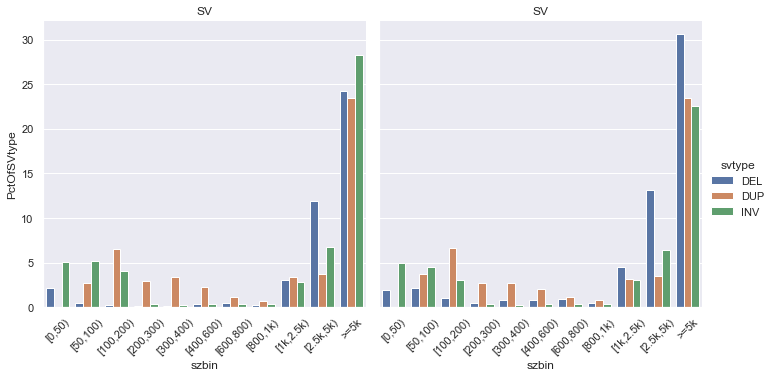

In [13]:
p = sb.catplot(data=view.reset_index(), col="known", kind="bar", 
           x="szbin", y="PctOfSVtype", hue="svtype", 
           hue_order=["DEL", "DUP", "INV"], order=data['szbin'].dtype.categories.to_list())
p.set(title="SV")
for axes in p.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

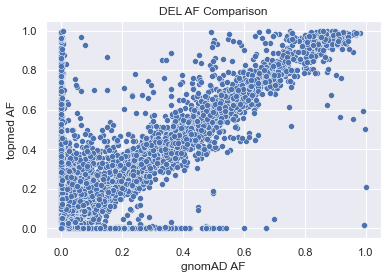

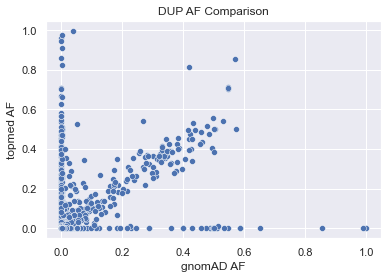

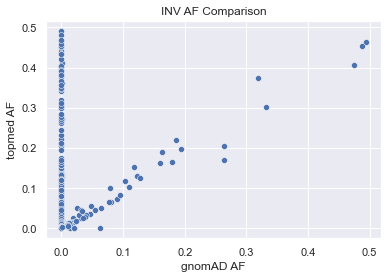

In [14]:
for i in ["DEL", "DUP", "INV"]:
    p = sb.scatterplot(data=data[data["is_gnomAD"] & (data["svtype"] == i)], x="GD_AF", y="AF")
    p.set(title=i + " AF Comparison", xlabel="gnomAD AF", ylabel="topmed AF")
    plt.show()

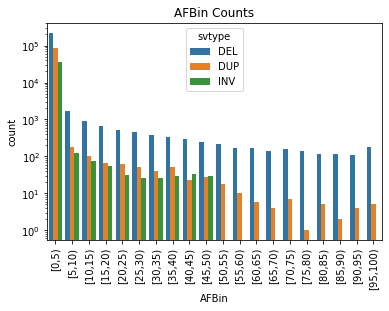

In [21]:
p = sb.countplot(data=data, x="AFBin", hue="svtype", hue_order=["DEL", "DUP", "INV"])
p.set(yscale="log", title="AFBin Counts")
hide = plt.xticks(rotation=90)

In [16]:
data[["UNK", "REF", "HET", "HOM"]] = pd.DataFrame(data['GTCNT'].tolist(), index=data.index)

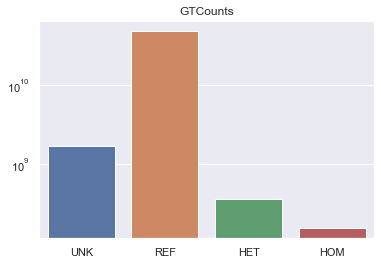

In [17]:
cnts = data[["UNK", "REF", "HET", "HOM"]].sum(axis=0)
p = sb.barplot(x=cnts.index, y=cnts.values)
hide = p.set(yscale="log", title="GTCounts")

In [18]:
singletons = data[["HET", "HOM"]].sum(axis=1) == 1
print("{:,d} singletons {:.2f}%".format(singletons.sum(), singletons.sum() / data.shape[0] * 100))

168,307 singletons 47.28%


In [19]:
data["missing_pct"] = data["UNK"] / data[["UNK", "REF", "HET", "HOM"]].sum(axis=1)

In [30]:
a = data[singletons]["svtype"].value_counts()

In [31]:
b = data["svtype"].value_counts()

In [32]:
view = pd.concat([a, b, a / b], axis=1)
view.columns = ["singletons", "total", "pct"]
view.dropna()

,singletons,total,pct
DEL,101346,231817,0.437181
DUP,45164,86911,0.519658
INV,21797,37226,0.585532


In [34]:
j = view.sum()
print(j["singletons"] / j["total"])

0.47283356838243146


In [40]:
x = (data["AF"] < 0.01).value_counts()
print(x)
print(x[True] / x.sum())

True     339766
False     16188
Name: AF, dtype: int64
0.9545222135444468


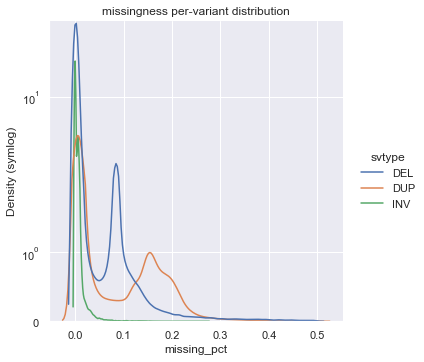

In [23]:
p = sb.displot(data=data, x="missing_pct", kind="kde", hue="svtype", hue_order=["DEL", "DUP", "INV"])
hide = p.set(yscale="symlog", title="missingness per-variant distribution", ylabel="Density (symlog)")

In [24]:
hits_gene = data["Gene_name"].isna()
hits_gene.value_counts()

False    183788
True     172166
Name: Gene_name, dtype: int64

In [25]:
len(data)

355954

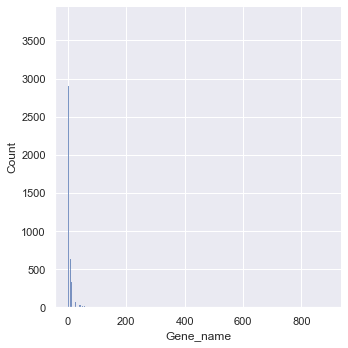

In [26]:
view = data["Gene_name"].value_counts().reset_index()
p = sb.displot(data = view, x="Gene_name")
#p.set(xlabels=[])
#view.head()

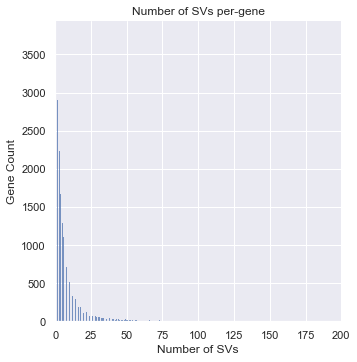

In [27]:
p = sb.displot(data = view, x="Gene_name")
p.set(xlim=(0,200), title="Number of SVs per-gene", xlabel="Number of SVs", ylabel="Gene Count")

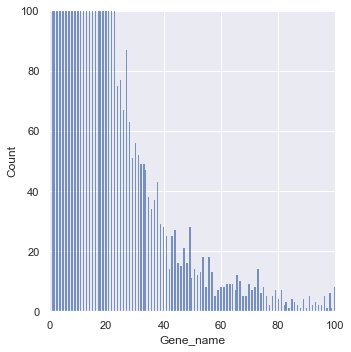

In [28]:
p = sb.displot(data = view, x="Gene_name")
p.set(xlim=(0,100), ylim=(0, 100))

In [7]:
samp_cnt = joblib.load("results/PerSampleSVCounts.jl")
cnts = []
print(samp_cnt.keys())
for key in samp_cnt:
    cnts.append(pd.Series(samp_cnt[key], name=key))
samp_cnt = pd.concat(cnts, axis=1)
samp_cnt["sample"] = open("results/VCFsamples.txt", 'r').readline().strip().split('\t')
samp_cnt["TOT"] = samp_cnt[["DEL", "DUP", "INV"]].sum(axis=1)
samp_cnt = samp_cnt.melt(id_vars=["sample"], value_vars=["DEL", "DUP", "INV", "TOT"])

dict_keys(['DEL', 'DUP', 'INV'])


In [8]:
anc = pd.read_csv("results/ancestries.txt")
anc_d = anc.set_index("NWDID")["Ancestry"].to_dict()
samp_cnt["ancestry"] = samp_cnt["sample"].map(anc_d)

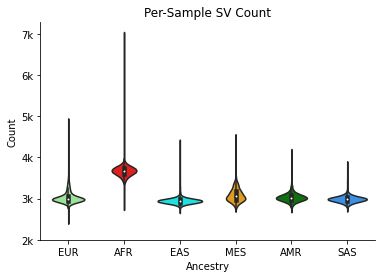

In [83]:
p = sb.violinplot(data=samp_cnt[(samp_cnt["variable"] == "TOT") & (samp_cnt["ancestry"] != "OCN")],
                  x="ancestry", y="value", palette=pop_colours)
sb.despine()
hide = plt.yticks(range(2500, 8000, 1000), ["{:,d}k".format(x // 1000) for x in range(2500, 8000, 1000)])
hide = p.set(title="Per-Sample SV Count", ylabel="Count", xlabel="Ancestry")

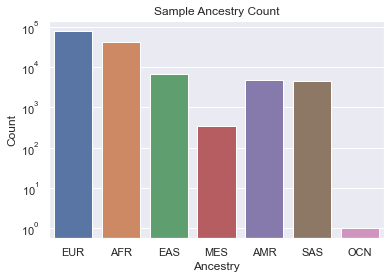

In [158]:
p = sb.countplot(data=anc, x="Ancestry")
hide = p.set(title="Sample Ancestry Count", ylabel="Count", yscale="log")

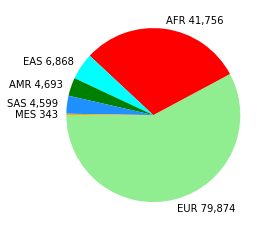

In [18]:
j = anc["Ancestry"].value_counts()
j = pd.DataFrame(j)
j = j[j["Ancestry"] > 10]
j["Pct"] = j["Ancestry"] / j["Ancestry"].sum() * 100
j.reset_index(inplace=True)
labels = ["{} {:,d}".format(x[1]["index"], int(x[1].Ancestry)) for x in j[["index", "Ancestry"]].iterrows()]
j["color"] = j["index"].map(pop_colours)
p = plt.pie(j["Ancestry"], labels = labels, startangle=180, colors=j["color"])

In [205]:
j[j["Ancestry"] > 10]["Ancestry"]

0    79874
1    41756
2     6868
3     4693
4     4599
5      343
Name: Ancestry, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '[0,1kb)'),
  Text(1, 0, '[1kb, 5kb)'),
  Text(2, 0, '[5kb, 10kb)'),
  Text(3, 0, '[10kb, 20kb)'),
  Text(4, 0, '[20kb, 50kb)'),
  Text(5, 0, '[50kb, 100kb)'),
  Text(6, 0, '100kb+')])

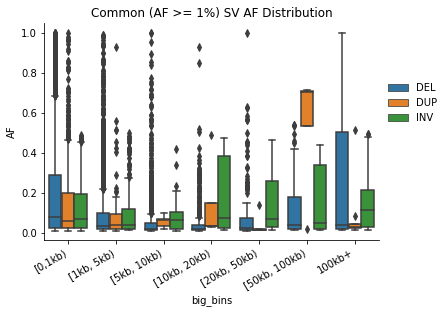

In [60]:
p = sb.boxplot(data=data[data["AF"] >= 0.01], x="big_bins", y="AF", hue="svtype", hue_order=["DEL", "DUP", "INV"])
p.set(title="Common (AF >= 1%) SV AF Distribution")
sb.despine()
sb.move_legend(p, "lower center",
    bbox_to_anchor=(1.1, .5),
    #nrow=3,
    title=None,
    frameon=False,)
plt.xticks(rotation=30, ha="right")

x = data.index
out = open("topmed.sv.bed", 'w')
for i in x:
    h,t = i.split('.')
    c,p = h.split(':')
    s,e = p.split('-')
    out.write(f"{c}\t{s}\t{e}\t{t}\n")